In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import logging

module_path = os.path.abspath(os.path.join("../../.."))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from pathlib import Path

import torch
import torch.utils.data
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt

import pvi
from pvi.models import ClassificationBNNLocalRepam
from pvi.clients import Client
from pvi.servers import SequentialServer
from pvi.distributions import MeanFieldGaussianDistribution, MeanFieldGaussianFactor
from pvi.utils.training_utils import EarlyStopping

In [2]:
data_dir = Path("/Users/terjemildner/Desktop/data")
cache_dir = Path("/Users/terjemildner/Desktop/PVI-main/experiments/femnist")

## Define various functions for splitting data and recording performance metrics.

In [3]:
# Data splitting functions.
def homogeneous_split(data, num_clients=100, seed=78637921):
    # Set numpy's random seed.
    np.random.seed(seed)
    
    perm = np.random.permutation(len(data["x"]))
    client_data = []
    for i in range(num_clients):
        client_idx = perm[i::num_clients]
        client_data.append({"x": data["x"][client_idx], "y": data["y"][client_idx]})
    
    return client_data


# Performance metric function. Why is the batch size 512 when the split gives 600? => Mini batches?
def performance_metrics(client, data, batch_size=512):
    dataset = torch.utils.data.TensorDataset(data["x"], data["y"])
    loader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=False)
    
    device = client.config["device"]
    
    if device == "cuda":
        loader.pin_memory = True
        
    preds, mlls = [], []
    for (x_batch, y_batch) in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        pp = client.model_predict(x_batch)
        preds.append(pp.component_distribution.probs.mean(1).cpu())
        mlls.append(pp.log_prob(y_batch).cpu())
        
    mll = torch.cat(mlls).mean()
    preds = torch.cat(preds)
    acc = sum(torch.argmax(preds, dim=-1) == loader.dataset.tensors[1]) / len(
        loader.dataset.tensors[1]
    )
    
    return {"mll": mll, "acc": acc}

## Data preprocessing

In [4]:
transform_train = transforms.Compose([transforms.ToTensor()])
transform_test = transforms.Compose([transforms.ToTensor()])

train_set = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform_train)
test_set = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform_test)

train_data = {
    "x": torch.tensor(((train_set.data - 0) / 255).reshape(-1, 3 * 32 * 32), dtype=torch.float32),
    "y": torch.tensor(train_set.targets),
}

test_data = {
    "x": torch.tensor(((test_set.data - 0) / 255).reshape(-1, 3 * 32 * 32), dtype=torch.float32),
    "y": torch.tensor(test_set.targets),
}

Files already downloaded and verified
Files already downloaded and verified


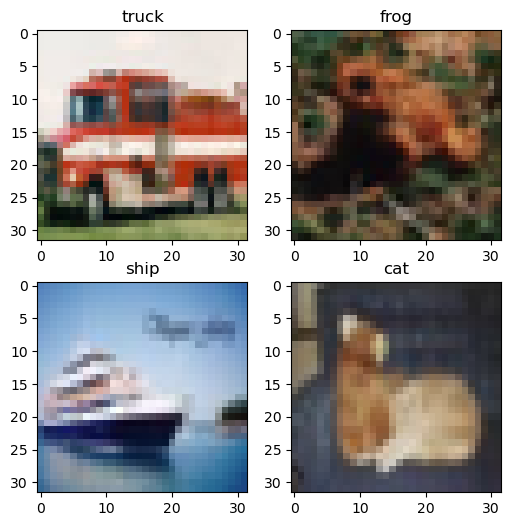

In [9]:
img, lab = train_set[7373]
img2, lab2 = train_set[14999]
img3, lab3 = train_set[48726]
img4, lab4 = train_set[17]
fig, axs = plt.subplots(2,2, figsize=(6,6))
axs[0,0].imshow(img.permute(1,2,0))
axs[0,0].set_title(train_set.classes[lab])
axs[0,1].imshow(img2.permute(1,2,0))
axs[0,1].set_title(train_set.classes[lab2])
axs[1,0].imshow(img3.permute(1,2,0))
axs[1,0].set_title(train_set.classes[lab3])
axs[1,1].imshow(img4.permute(1,2,0))
axs[1,1].set_title(train_set.classes[lab4])
plt.show()

In [11]:
imgs = torch.stack([img_t for img_t, _ in train_set], dim=3)

In [12]:
imgs.view(3,-1).mean(dim=1)

tensor([0.4914, 0.4822, 0.4465])

In [13]:
imgs.view(3,-1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

In [14]:
transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))

In [19]:
train_set_n = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))]))
test_set_n = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))]))

train_data_n = {
    "x": torch.tensor(((train_set_n.data - 0) / 255).reshape(-1, 3 * 32 * 32), dtype=torch.float32),
    "y": torch.tensor(train_set_n.targets),
}

test_data_n = {
    "x": torch.tensor(((test_set_n.data - 0) / 255).reshape(-1, 3 * 32 * 32), dtype=torch.float32),
    "y": torch.tensor(test_set_n.targets),
}

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


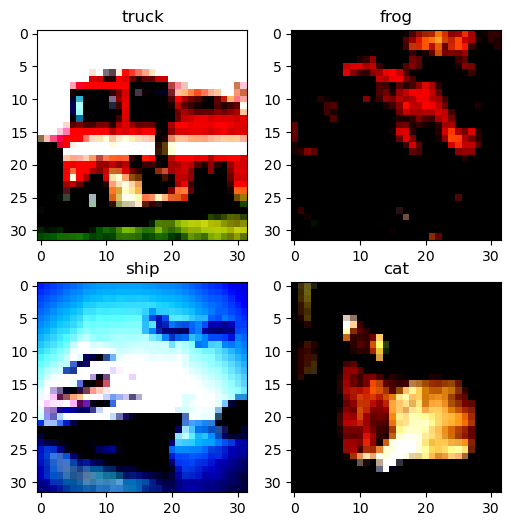

In [20]:
img, lab = train_set_n[7373]
img2, lab2 = train_set_n[14999]
img3, lab3 = train_set_n[48726]
img4, lab4 = train_set_n[17]
fig, axs = plt.subplots(2,2, figsize=(6,6))
axs[0,0].imshow(img.permute(1,2,0))
axs[0,0].set_title(train_set.classes[lab])
axs[0,1].imshow(img2.permute(1,2,0))
axs[0,1].set_title(train_set.classes[lab2])
axs[1,0].imshow(img3.permute(1,2,0))
axs[1,0].set_title(train_set.classes[lab3])
axs[1,1].imshow(img4.permute(1,2,0))
axs[1,1].set_title(train_set.classes[lab4])
plt.show()

In [21]:
# Get client splits.
client_data = homogeneous_split(train_data_n, 10, seed=42)


In [23]:
client_data[0]["x"][0]

tensor([0.7255, 0.7255, 0.6980,  ..., 0.4157, 0.4118, 0.4431])

## Define configuration for server and clients

In [32]:
model_config = {
    "input_dim": 3072,
    "latent_dim": 256,
    "output_dim": 10,
    "num_layers": 1,
    "num_predictive_samples": 100,
    "prior_var": 1.0,
}

client_config = {
    "damping_factor": 1.0,
    "optimiser": "Adam",
    "optimiser_params": {"lr": 0.003},
    "sigma_optimiser_params": {"lr": 0.003},
    "early_stopping": EarlyStopping(20, score_name="elbo", stash_model=True),
    "performance_metrics": performance_metrics,
    "batch_size": 1024,
    "epochs": 1000,
    "print_epochs": np.inf,
    "num_elbo_samples": 10,
    "valid_factors": False,
    "device": "cpu",
    "init_var": 1e-3,
    "verbose": True,
}

server_config = {
    **client_config,
    #100
    "max_iterations": 100,
}

## Set up model etc.

In [33]:
device = server_config["device"]

model = ClassificationBNNLocalRepam(config=model_config)

# Initial parameters.
init_q_std_params = {
    "loc": torch.zeros(size=(model.num_parameters,)).to(device).uniform_(-0.1, 0.1),
    "scale": torch.ones(size=(model.num_parameters,)).to(device) 
    * client_config["init_var"] ** 0.5,
}

prior_std_params = {
    "loc": torch.zeros(size=(model.num_parameters,)).to(device),
    "scale": model_config["prior_var"] ** 0.5 
    * torch.ones(size=(model.num_parameters,)).to(device),
}

init_factor_nat_params = {
    "np1": torch.zeros(model.num_parameters).to(device),
    "np2": torch.zeros(model.num_parameters).to(device),
}

p = MeanFieldGaussianDistribution(
    std_params=prior_std_params, is_trainable=False
)
init_q = MeanFieldGaussianDistribution(
    std_params=init_q_std_params, is_trainable=False
)

clients = []
size_training = 0
for i in range(10):
    data_i = client_data[i]
    size_training += len(data_i["x"])
    t_i = MeanFieldGaussianFactor(nat_params=init_factor_nat_params)
    clients.append(
        Client(
            data=data_i,
            model=model,
            t=t_i,
            config=client_config,
            val_data=test_data_n
        )
    )    
server = SequentialServer(model=model, p=p, clients=clients, config=server_config, init_q=init_q, data=train_data_n, val_data=test_data_n)

## Run PVI! 2 Hidden Layer

In [34]:
i = 0
while not server.should_stop():
    server.tick()

    # Obtain performance metrics.
    metrics = server.log["performance_metrics"][-1]
    print("Iterations: {}.".format(i))
    print("Time taken: {:.3f}.".format(metrics["time"]))
    print(
      "Test mll: {:.3f}. Test acc: {:.3f}.".format(
          metrics["val_mll"], metrics["val_acc"]
      )
    )
    print(
      "Train mll: {:.3f}. Train acc: {:.3f}.\n".format(
          metrics["train_mll"], metrics["train_acc"]
      )
    )
    i += 1

0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 0.
Time taken: 603.864.
Test mll: -1.761. Test acc: 0.367.
Train mll: -1.757. Train acc: 0.370.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 1.
Time taken: 774.124.
Test mll: -1.741. Test acc: 0.378.
Train mll: -1.739. Train acc: 0.379.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 2.
Time taken: 964.916.
Test mll: -1.733. Test acc: 0.381.
Train mll: -1.732. Train acc: 0.381.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 3.
Time taken: 1128.452.
Test mll: -1.729. Test acc: 0.381.
Train mll: -1.726. Train acc: 0.382.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 4.
Time taken: 1299.099.
Test mll: -1.728. Test acc: 0.384.
Train mll: -1.725. Train acc: 0.386.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 5.
Time taken: 1468.742.
Test mll: -1.725. Test acc: 0.387.
Train mll: -1.722. Train acc: 0.386.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 6.
Time taken: 1640.568.
Test mll: -1.723. Test acc: 0.392.
Train mll: -1.722. Train acc: 0.388.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 7.
Time taken: 1804.514.
Test mll: -1.724. Test acc: 0.386.
Train mll: -1.722. Train acc: 0.387.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 8.
Time taken: 1974.807.
Test mll: -1.719. Test acc: 0.394.
Train mll: -1.717. Train acc: 0.391.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 9.
Time taken: 2133.161.
Test mll: -1.717. Test acc: 0.388.
Train mll: -1.714. Train acc: 0.392.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 10.
Time taken: 2293.773.
Test mll: -1.716. Test acc: 0.392.
Train mll: -1.713. Train acc: 0.394.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 11.
Time taken: 2460.552.
Test mll: -1.713. Test acc: 0.395.
Train mll: -1.711. Train acc: 0.395.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 12.
Time taken: 2629.156.
Test mll: -1.714. Test acc: 0.394.
Train mll: -1.712. Train acc: 0.391.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 13.
Time taken: 2803.032.
Test mll: -1.713. Test acc: 0.393.
Train mll: -1.710. Train acc: 0.395.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 14.
Time taken: 2979.013.
Test mll: -1.710. Test acc: 0.392.
Train mll: -1.706. Train acc: 0.394.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 15.
Time taken: 3129.879.
Test mll: -1.705. Test acc: 0.396.
Train mll: -1.703. Train acc: 0.395.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 16.
Time taken: 3295.411.
Test mll: -1.704. Test acc: 0.396.
Train mll: -1.701. Train acc: 0.395.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 17.
Time taken: 3465.056.
Test mll: -1.701. Test acc: 0.400.
Train mll: -1.697. Train acc: 0.397.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 18.
Time taken: 3668.948.
Test mll: -1.703. Test acc: 0.396.
Train mll: -1.701. Train acc: 0.395.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 19.
Time taken: 3839.120.
Test mll: -1.701. Test acc: 0.396.
Train mll: -1.699. Train acc: 0.396.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 20.
Time taken: 4000.130.
Test mll: -1.700. Test acc: 0.394.
Train mll: -1.696. Train acc: 0.398.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 21.
Time taken: 5105.051.
Test mll: -1.702. Test acc: 0.396.
Train mll: -1.698. Train acc: 0.397.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 22.
Time taken: 5939.749.
Test mll: -1.697. Test acc: 0.400.
Train mll: -1.695. Train acc: 0.399.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 23.
Time taken: 6239.395.
Test mll: -1.702. Test acc: 0.401.
Train mll: -1.699. Train acc: 0.399.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 24.
Time taken: 6700.995.
Test mll: -1.700. Test acc: 0.398.
Train mll: -1.697. Train acc: 0.396.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 25.
Time taken: 7534.146.
Test mll: -1.697. Test acc: 0.401.
Train mll: -1.693. Train acc: 0.400.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 26.
Time taken: 7688.871.
Test mll: -1.701. Test acc: 0.397.
Train mll: -1.698. Train acc: 0.398.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 27.
Time taken: 7848.772.
Test mll: -1.699. Test acc: 0.396.
Train mll: -1.697. Train acc: 0.399.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 28.
Time taken: 7991.698.
Test mll: -1.694. Test acc: 0.400.
Train mll: -1.693. Train acc: 0.401.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 29.
Time taken: 8157.663.
Test mll: -1.696. Test acc: 0.398.
Train mll: -1.693. Train acc: 0.400.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 30.
Time taken: 8325.142.
Test mll: -1.700. Test acc: 0.397.
Train mll: -1.695. Train acc: 0.398.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 31.
Time taken: 8490.639.
Test mll: -1.700. Test acc: 0.398.
Train mll: -1.698. Train acc: 0.396.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 32.
Time taken: 8634.730.
Test mll: -1.702. Test acc: 0.395.
Train mll: -1.698. Train acc: 0.399.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 33.
Time taken: 8789.326.
Test mll: -1.698. Test acc: 0.398.
Train mll: -1.695. Train acc: 0.400.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 34.
Time taken: 8947.802.
Test mll: -1.699. Test acc: 0.398.
Train mll: -1.697. Train acc: 0.399.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 35.
Time taken: 9107.460.
Test mll: -1.698. Test acc: 0.397.
Train mll: -1.697. Train acc: 0.399.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 36.
Time taken: 9249.304.
Test mll: -1.699. Test acc: 0.398.
Train mll: -1.696. Train acc: 0.398.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 37.
Time taken: 9403.831.
Test mll: -1.700. Test acc: 0.397.
Train mll: -1.697. Train acc: 0.400.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 38.
Time taken: 9569.717.
Test mll: -1.695. Test acc: 0.398.
Train mll: -1.693. Train acc: 0.399.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 39.
Time taken: 9743.682.
Test mll: -1.700. Test acc: 0.397.
Train mll: -1.696. Train acc: 0.399.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 40.
Time taken: 9900.849.
Test mll: -1.696. Test acc: 0.396.
Train mll: -1.692. Train acc: 0.399.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 41.
Time taken: 10052.756.
Test mll: -1.701. Test acc: 0.398.
Train mll: -1.696. Train acc: 0.398.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 42.
Time taken: 10223.645.
Test mll: -1.700. Test acc: 0.397.
Train mll: -1.697. Train acc: 0.397.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 43.
Time taken: 10385.605.
Test mll: -1.698. Test acc: 0.398.
Train mll: -1.695. Train acc: 0.398.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 44.
Time taken: 10566.708.
Test mll: -1.700. Test acc: 0.393.
Train mll: -1.696. Train acc: 0.395.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 45.
Time taken: 10712.448.
Test mll: -1.702. Test acc: 0.395.
Train mll: -1.698. Train acc: 0.397.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 46.
Time taken: 10882.233.
Test mll: -1.700. Test acc: 0.396.
Train mll: -1.696. Train acc: 0.398.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 47.
Time taken: 11055.193.
Test mll: -1.704. Test acc: 0.389.
Train mll: -1.700. Train acc: 0.395.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 48.
Time taken: 11210.347.
Test mll: -1.702. Test acc: 0.395.
Train mll: -1.699. Train acc: 0.392.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 49.
Time taken: 11354.663.
Test mll: -1.699. Test acc: 0.398.
Train mll: -1.695. Train acc: 0.400.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 50.
Time taken: 11515.517.
Test mll: -1.698. Test acc: 0.395.
Train mll: -1.696. Train acc: 0.394.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 51.
Time taken: 11669.622.
Test mll: -1.696. Test acc: 0.399.
Train mll: -1.692. Train acc: 0.399.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 52.
Time taken: 11830.407.
Test mll: -1.698. Test acc: 0.397.
Train mll: -1.693. Train acc: 0.397.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 53.
Time taken: 11965.108.
Test mll: -1.697. Test acc: 0.395.
Train mll: -1.694. Train acc: 0.395.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 54.
Time taken: 12130.400.
Test mll: -1.697. Test acc: 0.398.
Train mll: -1.693. Train acc: 0.399.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 55.
Time taken: 12313.823.
Test mll: -1.694. Test acc: 0.398.
Train mll: -1.692. Train acc: 0.399.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 56.
Time taken: 12483.358.
Test mll: -1.696. Test acc: 0.398.
Train mll: -1.691. Train acc: 0.399.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 57.
Time taken: 12638.985.
Test mll: -1.695. Test acc: 0.395.
Train mll: -1.691. Train acc: 0.400.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 58.
Time taken: 12799.974.
Test mll: -1.694. Test acc: 0.402.
Train mll: -1.692. Train acc: 0.400.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 59.
Time taken: 12969.914.
Test mll: -1.697. Test acc: 0.399.
Train mll: -1.692. Train acc: 0.400.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 60.
Time taken: 13134.728.
Test mll: -1.696. Test acc: 0.401.
Train mll: -1.693. Train acc: 0.401.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 61.
Time taken: 13289.317.
Test mll: -1.697. Test acc: 0.398.
Train mll: -1.693. Train acc: 0.399.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 62.
Time taken: 13460.571.
Test mll: -1.698. Test acc: 0.400.
Train mll: -1.693. Train acc: 0.399.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 63.
Time taken: 13621.203.
Test mll: -1.695. Test acc: 0.397.
Train mll: -1.691. Train acc: 0.400.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 64.
Time taken: 13792.648.
Test mll: -1.696. Test acc: 0.401.
Train mll: -1.693. Train acc: 0.400.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 65.
Time taken: 13948.937.
Test mll: -1.696. Test acc: 0.399.
Train mll: -1.690. Train acc: 0.398.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 66.
Time taken: 14121.649.
Test mll: -1.699. Test acc: 0.398.
Train mll: -1.695. Train acc: 0.398.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 67.
Time taken: 14271.441.
Test mll: -1.695. Test acc: 0.401.
Train mll: -1.692. Train acc: 0.400.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 68.
Time taken: 14440.194.
Test mll: -1.697. Test acc: 0.399.
Train mll: -1.693. Train acc: 0.399.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 69.
Time taken: 14609.739.
Test mll: -1.697. Test acc: 0.401.
Train mll: -1.692. Train acc: 0.399.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 70.
Time taken: 14772.987.
Test mll: -1.695. Test acc: 0.400.
Train mll: -1.689. Train acc: 0.402.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 71.
Time taken: 14931.265.
Test mll: -1.692. Test acc: 0.401.
Train mll: -1.689. Train acc: 0.401.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 72.
Time taken: 15083.377.
Test mll: -1.695. Test acc: 0.403.
Train mll: -1.690. Train acc: 0.404.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 73.
Time taken: 15245.061.
Test mll: -1.694. Test acc: 0.402.
Train mll: -1.689. Train acc: 0.401.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 74.
Time taken: 15413.827.
Test mll: -1.693. Test acc: 0.399.
Train mll: -1.688. Train acc: 0.402.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 75.
Time taken: 15563.918.
Test mll: -1.693. Test acc: 0.398.
Train mll: -1.690. Train acc: 0.399.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 76.
Time taken: 15721.433.
Test mll: -1.694. Test acc: 0.401.
Train mll: -1.689. Train acc: 0.401.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 77.
Time taken: 15883.378.
Test mll: -1.699. Test acc: 0.398.
Train mll: -1.693. Train acc: 0.401.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 78.
Time taken: 16055.464.
Test mll: -1.699. Test acc: 0.400.
Train mll: -1.693. Train acc: 0.402.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 79.
Time taken: 16225.791.
Test mll: -1.697. Test acc: 0.399.
Train mll: -1.692. Train acc: 0.398.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 80.
Time taken: 16375.808.
Test mll: -1.696. Test acc: 0.398.
Train mll: -1.692. Train acc: 0.397.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 81.
Time taken: 16538.994.
Test mll: -1.695. Test acc: 0.397.
Train mll: -1.689. Train acc: 0.400.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 82.
Time taken: 16704.610.
Test mll: -1.694. Test acc: 0.400.
Train mll: -1.689. Train acc: 0.402.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 83.
Time taken: 16858.135.
Test mll: -1.695. Test acc: 0.398.
Train mll: -1.690. Train acc: 0.400.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 84.
Time taken: 17026.580.
Test mll: -1.698. Test acc: 0.399.
Train mll: -1.691. Train acc: 0.400.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 85.
Time taken: 17196.783.
Test mll: -1.694. Test acc: 0.397.
Train mll: -1.690. Train acc: 0.399.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 86.
Time taken: 17366.661.
Test mll: -1.693. Test acc: 0.400.
Train mll: -1.690. Train acc: 0.400.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 87.
Time taken: 17533.652.
Test mll: -1.695. Test acc: 0.401.
Train mll: -1.691. Train acc: 0.400.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 88.
Time taken: 17681.135.
Test mll: -1.695. Test acc: 0.400.
Train mll: -1.689. Train acc: 0.400.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 89.
Time taken: 17844.044.
Test mll: -1.694. Test acc: 0.399.
Train mll: -1.691. Train acc: 0.398.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 90.
Time taken: 18003.268.
Test mll: -1.697. Test acc: 0.398.
Train mll: -1.692. Train acc: 0.402.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 91.
Time taken: 18163.830.
Test mll: -1.694. Test acc: 0.396.
Train mll: -1.691. Train acc: 0.397.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 92.
Time taken: 18328.100.
Test mll: -1.694. Test acc: 0.398.
Train mll: -1.690. Train acc: 0.400.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 93.
Time taken: 18482.977.
Test mll: -1.697. Test acc: 0.396.
Train mll: -1.694. Train acc: 0.396.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 94.
Time taken: 18655.298.
Test mll: -1.695. Test acc: 0.398.
Train mll: -1.692. Train acc: 0.398.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 95.
Time taken: 18819.129.
Test mll: -1.695. Test acc: 0.400.
Train mll: -1.690. Train acc: 0.401.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 96.
Time taken: 18973.072.
Test mll: -1.698. Test acc: 0.398.
Train mll: -1.694. Train acc: 0.397.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 97.
Time taken: 19140.655.
Test mll: -1.693. Test acc: 0.401.
Train mll: -1.690. Train acc: 0.402.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 98.
Time taken: 19314.893.
Test mll: -1.694. Test acc: 0.397.
Train mll: -1.690. Train acc: 0.399.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 99.
Time taken: 19473.366.
Test mll: -1.694. Test acc: 0.398.
Train mll: -1.692. Train acc: 0.398.



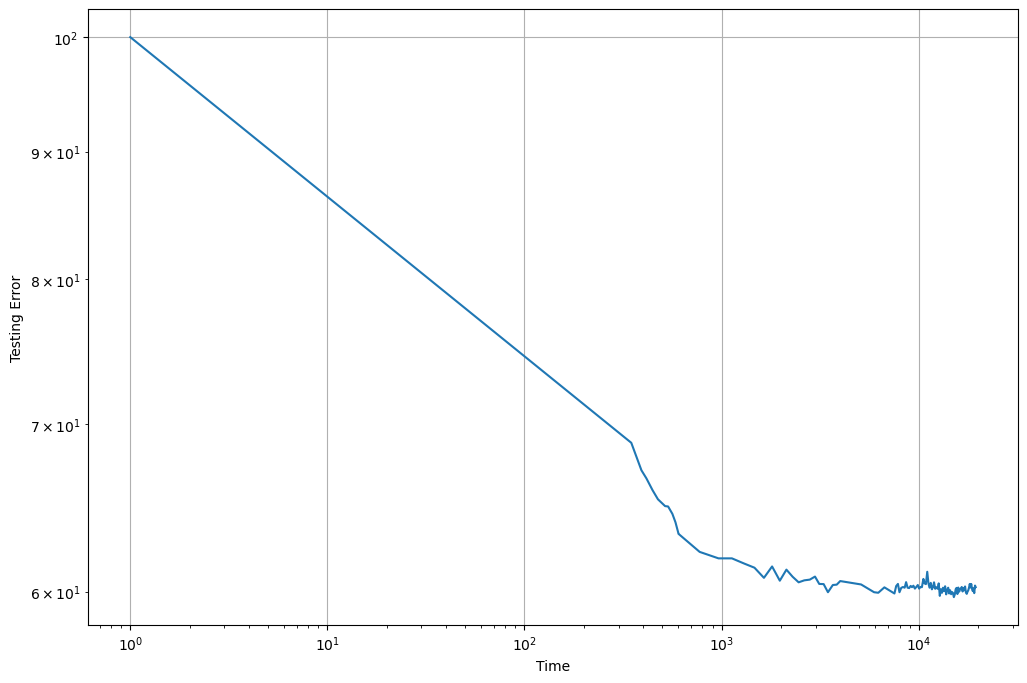

In [35]:
train_acc = []
val_acc = []
times = []
train_acc.append(100.0)
val_acc.append(100.0)
times.append(1.0)
for metrics in server.log["performance_metrics"]:
    train_acc.append(100-metrics["train_acc"]*100)
    val_acc.append(100-metrics["val_acc"]*100)
    times.append(metrics["time"])
plt.figure(figsize=(12,8))
plt.xscale("log")
plt.yscale("log")
plt.plot(times, val_acc)
plt.xlabel("Time")
plt.ylabel("Testing Error")
plt.grid(visible=True)
#plt.savefig("PVI on MNIST, lr=0.002.png")

plt.show()